# XGBoost on dEdX + Residual Range Percentiles

Trains two XGBoost models on per-track percentile features computed from the hit-level sequences:
- **3-percentile model**: mean + 25th/50th/75th (8 features)
- **5-percentile model**: mean + 10th/25th/50th/75th/90th (12 features)

In [ ]:
import os, sys

# Run from project root regardless of where the notebook is opened from
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
_utils = os.path.join(os.getcwd(), 'utils')
if _utils not in sys.path:
    sys.path.insert(0, _utils)

import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
from general_utils import purity, efficiency, create_confusion_matrix

np.random.seed(42)

## Data Loading

Load the hit-level 100k dataset (same as the CNN) and define a function to extract percentile features.

In [6]:
PION_LABEL = 2

data = pickle.load(open("extracted-data-hit/data_100000_split.pkl", "rb"))
x_train_raw = data['x_train']  # (N, 120, 2)
x_test_raw  = data['x_test']
y_train = (data['y_train'] == PION_LABEL).astype(int)
y_test  = (data['y_test']  == PION_LABEL).astype(int)


def extract_features(x, percentiles):
    """Compute mean + given percentiles of dEdX and RR per track, ignoring padding."""
    n_feats = 2 * (1 + len(percentiles))
    features = []
    for track in x:
        mask = np.any(track != 0, axis=1)
        real_hits = track[mask]
        if len(real_hits) == 0:
            features.append(np.zeros(n_feats))
            continue
        dedx, rr = real_hits[:, 0], real_hits[:, 1]
        row = [np.mean(dedx)] + [np.percentile(dedx, p) for p in percentiles] + \
              [np.mean(rr)]   + [np.percentile(rr,   p) for p in percentiles]
        features.append(row)
    return np.array(features, dtype=np.float32)


print("Extracting 3-percentile features (25/50/75)...")
x_train_p3 = extract_features(x_train_raw, [25, 50, 75])
x_test_p3  = extract_features(x_test_raw,  [25, 50, 75])

print("Extracting 5-percentile features (10/25/50/75/90)...")
x_train_p5 = extract_features(x_train_raw, [10, 25, 50, 75, 90])
x_test_p5  = extract_features(x_test_raw,  [10, 25, 50, 75, 90])

print(f"\nx_train_p3: {x_train_p3.shape}, x_train_p5: {x_train_p5.shape}")
print(f"Train: {y_train.sum()} pions / {len(y_train)} total ({100*y_train.mean():.1f}%)")
print(f"Test:  {y_test.sum()}  pions / {len(y_test)}  total ({100*y_test.mean():.1f}%)")

/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.1.3 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Extracting 3-percentile features (25/50/75)...
Extracting 5-percentile features (10/25/50/75/90)...

x_train_p3: (34123, 8), x_train_p5: (34123, 12)
Train: 6105 pions / 34123 total (17.9%)
Test:  1555  pions / 8531  total (18.2%)


## Train & Evaluate Both Models

In [7]:
from sklearn.metrics import roc_curve, auc as sklearn_auc

def train_and_evaluate(x_tr, x_te, y_tr, y_te, model_name, save_path):
    model = XGBClassifier(max_depth=5, learning_rate=0.2, n_estimators=50,
                          random_state=42, eval_metric='logloss')
    model.fit(x_tr, y_tr)

    test_probs = model.predict_proba(x_te)[:, 1]

    # Threshold scan
    thresholds = np.arange(0.05, 0.96, 0.01)
    purities_scan, efficiencies_scan = [], []
    for t in thresholds:
        preds = (test_probs >= t).astype(int)
        purities_scan.append(purity(preds, y_te, [1], [1]))
        efficiencies_scan.append(efficiency(preds, y_te, [1], [1]))
    purities_scan = np.array(purities_scan)
    efficiencies_scan = np.array(efficiencies_scan)
    best_idx = np.argmax(purities_scan * efficiencies_scan)
    best_threshold = thresholds[best_idx]

    final_preds = (test_probs >= best_threshold).astype(int)
    pur_val, pur_unc = purity(final_preds, y_te, [1], [1], return_uncertainty=True)
    eff_val, eff_unc = efficiency(final_preds, y_te, [1], [1], return_uncertainty=True)
    fpr, tpr, _ = roc_curve(y_te, test_probs)
    roc_auc = sklearn_auc(fpr, tpr)

    print(f"=== {model_name} ===")
    print(f"  Threshold: {best_threshold:.2f}  |  AUC: {roc_auc:.3f}")
    print(f"  Purity:     {100*pur_val:.1f}% ± {100*pur_unc:.1f}%")
    print(f"  Efficiency: {100*eff_val:.1f}% ± {100*eff_unc:.1f}%")
    print(f"  Product:    {100*pur_val*eff_val:.1f}%\n")

    results = {
        "model_name": model_name,
        "probs": test_probs,
        "labels": y_te,
        "threshold": best_threshold,
        "purity": pur_val,
        "efficiency": eff_val,
        "auc": roc_auc
    }
    with open(save_path, "wb") as f:
        pickle.dump(results, f)
    print(f"  Saved to {save_path}")
    return results, model


results_p3, model_p3 = train_and_evaluate(
    x_train_p3, x_test_p3, y_train, y_test,
    model_name="XGBoost (p25/50/75 + mean)",
    save_path="results/xgb_p3.pkl"
)

results_p5, model_p5 = train_and_evaluate(
    x_train_p5, x_test_p5, y_train, y_test,
    model_name="XGBoost (p10/25/50/75/90 + mean)",
    save_path="results/xgb_p5.pkl"
)

=== XGBoost (p25/50/75 + mean) ===
  Threshold: 0.22  |  AUC: 0.849
  Purity:     46.7% ± 1.0%
  Efficiency: 70.5% ± 1.2%
  Product:    32.9%

  Saved to results/xgb_p3.pkl
=== XGBoost (p10/25/50/75/90 + mean) ===
  Threshold: 0.27  |  AUC: 0.856
  Purity:     52.1% ± 1.1%
  Efficiency: 66.6% ± 1.2%
  Product:    34.7%

  Saved to results/xgb_p5.pkl


## Feature Importances

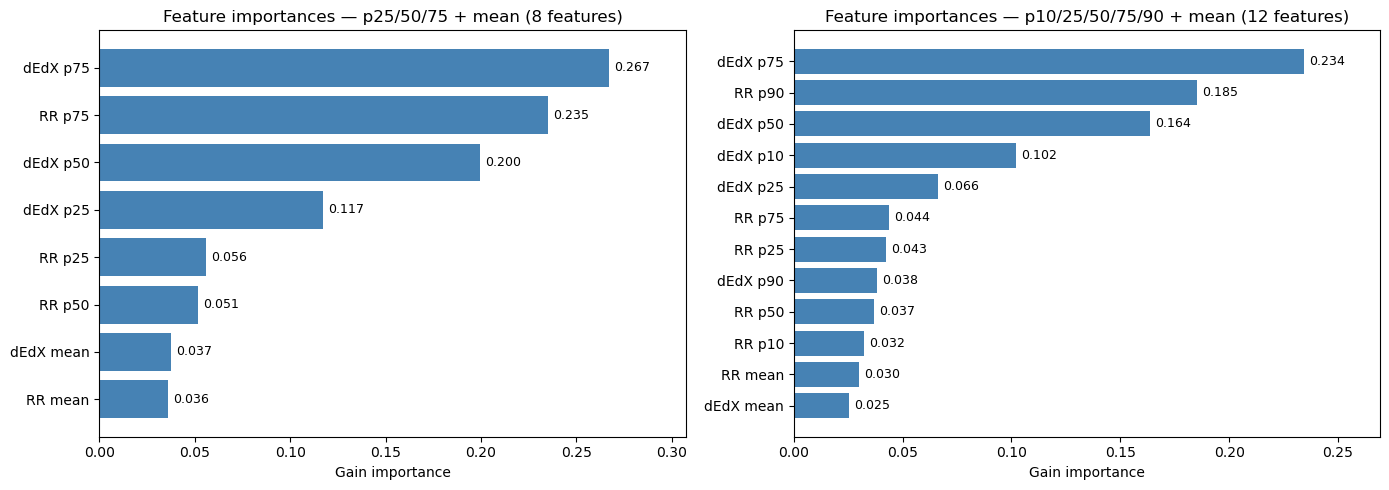

In [8]:
feat_names_p3 = ['dEdX mean', 'dEdX p25', 'dEdX p50', 'dEdX p75',
                 'RR mean',   'RR p25',   'RR p50',   'RR p75']

feat_names_p5 = ['dEdX mean', 'dEdX p10', 'dEdX p25', 'dEdX p50', 'dEdX p75', 'dEdX p90',
                 'RR mean',   'RR p10',   'RR p25',   'RR p50',   'RR p75',   'RR p90']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, model, names, title in [
    (axes[0], model_p3, feat_names_p3, 'p25/50/75 + mean (8 features)'),
    (axes[1], model_p5, feat_names_p5, 'p10/25/50/75/90 + mean (12 features)'),
]:
    importances = model.feature_importances_
    order = np.argsort(importances)
    ax.barh(np.array(names)[order], importances[order], color='steelblue')
    ax.set_xlabel('Gain importance')
    ax.set_title(f'Feature importances — {title}')
    ax.set_xlim(0, importances.max() * 1.15)
    for i, (v, idx) in enumerate(zip(importances[order], order)):
        ax.text(v + importances.max() * 0.01, i, f'{v:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## Feature Correlations

Pearson correlation between all dEdX and RR percentile features (computed on the training set). Highly correlated feature pairs carry redundant information — features in the same region of the dEdX or RR distribution will naturally be tightly correlated.

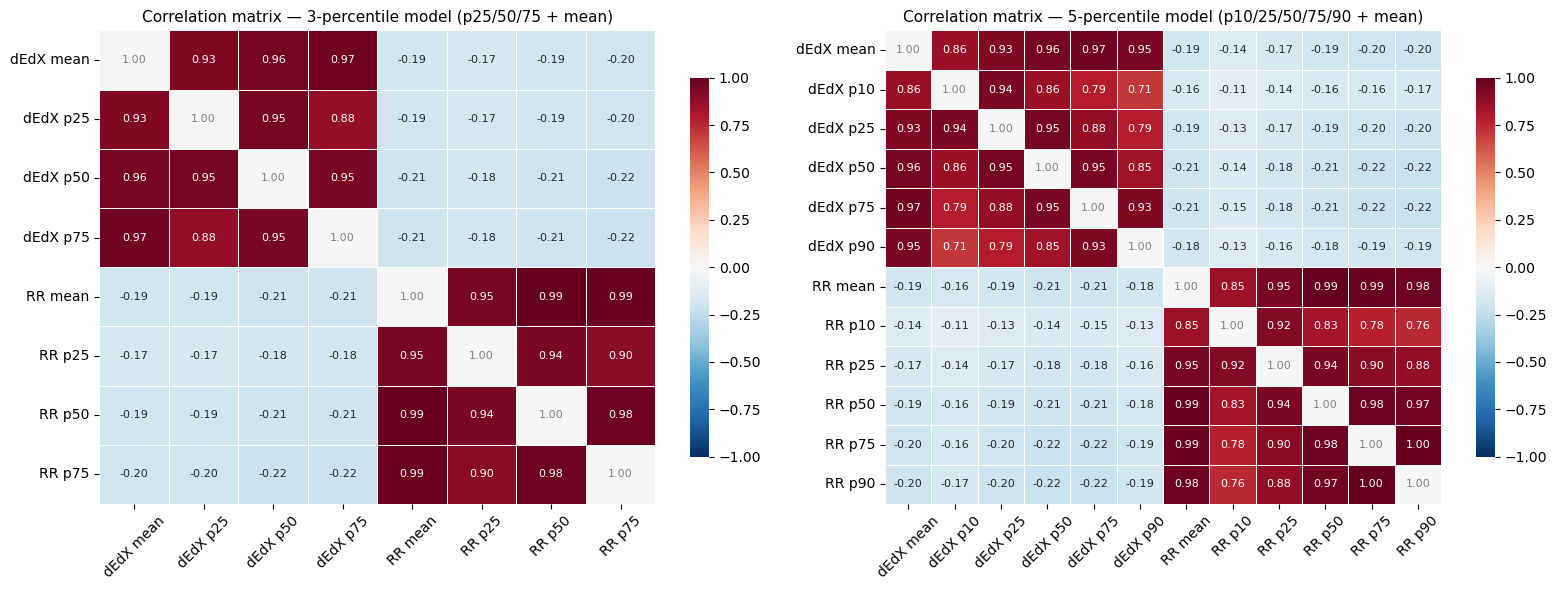

In [9]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, x, names, title in [
    (axes[0], x_train_p3, feat_names_p3, '3-percentile model (p25/50/75 + mean)'),
    (axes[1], x_train_p5, feat_names_p5, '5-percentile model (p10/25/50/75/90 + mean)'),
]:
    corr = pd.DataFrame(x, columns=names).corr()
    mask = np.eye(len(names), dtype=bool)  # mask diagonal for cleaner read
    sns.heatmap(
        corr, ax=ax,
        annot=True, fmt='.2f', annot_kws={'size': 8},
        cmap='RdBu_r', vmin=-1, vmax=1,
        linewidths=0.5, linecolor='white',
        mask=mask, cbar_kws={'shrink': 0.8}
    )
    # Restore diagonal labels (shown as blank due to mask)
    for i in range(len(names)):
        ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=True,
                                   color='whitesmoke', lw=0.5, ec='white'))
        ax.text(i + 0.5, i + 0.5, '1.00', ha='center', va='center',
                fontsize=8, color='gray')
    ax.set_title(f'Correlation matrix — {title}', fontsize=11)
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()